In [1]:
import pickle
import argparse
import traceback

import pandas as pd
import numpy as np

import itertools
import sklearn
import torch

from models.mlp import MLP
from data.datasets import TCGADataset, GTexDataset, GEODataset
from data.gene_graphs import GeneManiaGraph, RegNetGraph,HumanNetV1Graph, HumanNetV2Graph, \
    FunCoupGraph, HetIOGraph, StringDBGraph
from data.utils import record_result

import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

# Take home message

- Adam seems to work better than SGD
- We take the largest training set possible (9000) and train for the least number of epochs possible (1 seems to be enough)
- We then tweak the learning rate : 0.0007
- Weight decay : no regularization effect (almost no overfitting at the begining of training). We set it super low to 0.00000001
- Number of channels : no much effect (with one hidden layer) : we take 32
- Depth of the network : 0 hidden layer is bad, otherwise no effect. We take 1
- Batch size : 10 seems fine

# Initialization

In [3]:
datasetname = "tcga"
graph_name = "funcoup"
edge = "all"
trials = 1
#gnlist= ['NAMPT', 'ITGB8', 'RNF145', 'EGLN1', 'ANKHD1', 'CEACAM3', 'PRDX3', 'SERPINA4', 'CNTN1', 'B3GAT1'] #for hetio

In [4]:
def train(N):
    row = todo[N]
    gene = gnlist[N]

    print("gene", gene, "neighbors", len(list(gene_graph.first_degree(gene)[0])))

    seed = row["seed"]
    model = MLP(column_names=dataset.df.columns, num_layer=num_layer, dropout=dropout, 
                train_valid_split=train_valid_split, num_epochs=num_epochs,
                cuda=cuda, metric=sklearn.metrics.roc_auc_score, channels=channels, patience=patience,
                weight_decay=weight_decay, batch_size=batch_size, optimizer=optimizer, lr=lr, seed=0, 
                verbose=verbose)

    experiment = {
        "gene": gene,
        "model": "Basic_MLP",
        "graph": graph_name,
        "seed": seed,
        "train_size": train_size,
    }
    dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
    dataset.labels = dataset.labels.values if type(dataset.labels) == pd.Series else dataset.labels

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels,
                                                                                stratify=dataset.labels,
                                                                                train_size=train_size,
                                                                                test_size=test_size,
                                                                                random_state=seed)

    if is_first_degree:
        neighbors = list(gene_graph.first_degree(gene)[0])
        neighbors = [n for n in neighbors if n in X_train.columns.values]
        X_train = X_train.loc[:, neighbors].copy()
        X_test = X_test.loc[:, neighbors].copy()
    else:
        X_train = X_train.copy()
        X_test = X_test.copy()
    X_train[gene] = 1
    X_test[gene] = 1
    try:
        all_aucs_train, all_aucs_valid = model.fit(X_train, y_train)
#         y_hat = model.predict(X_test)
#         auc = sklearn.metrics.roc_auc_score(y_test, np.argmax(y_hat, axis=1))
#         experiment["auc"] = auc
        model.best_model = None  # cleanup
        del model
        torch.cuda.empty_cache()
        return all_aucs_train, all_aucs_valid
    except Exception:
        tb = traceback.format_exc()
        experiment['error'] = tb

In [5]:
def plot_training(baseline):
    print(train_size, test_size, num_layer, train_valid_split, channels, 
      patience,weight_decay, batch_size, optimizer, lr, num_epochs)
#     fig, (ax1, ax2) = plt.subplots(1, 2)
    bestlist = []
    diff = []
    for i in range(n_genes):
        all_aucs_train, all_aucs_valid = train(i)
        best = np.max(all_aucs_valid)
        bestlist.append(best)
        change =  best - baseline[i] 
        diff.append(change)
        print("Change in {} is {:.4f}\n".format(gnlist[i], change))
    print(np.mean(diff))
    return bestlist
        
#         ax1.plot(all_aucs_train, label=str(i))
#         ax2.plot(all_aucs_valid, label=str(i))

#     ax1.set_xlim(0, num_epochs)
#     ax1.set_ylim(0.5, 1)
#     ax2.set_xlim(0, num_epochs)
#     ax2.set_ylim(0.5, 1)
#     ax1.legend()
#     ax2.legend()
#     ax1.set_title("train with trainsize " + str(train_size))
#     ax2.set_title("valid with trainsize" + str(train_size))
#     plt.show()

In [6]:
results = pd.DataFrame(columns=['auc', 'gene', 'model', 'graph', 'seed', 'train_size', 'error'])
cuda = torch.cuda.is_available()

graph_dict = {"regnet": RegNetGraph, "genemania": GeneManiaGraph, "humannetv1": HumanNetV1Graph,
              "humannetv2": HumanNetV2Graph, "funcoup": FunCoupGraph,
              "hetio": HetIOGraph, "stringdb": StringDBGraph}

if graph_name == 'hetio' or graph_name == 'stringdb':
    gene_graph = graph_dict[graph_name](graph_type=edge)
else:
    gene_graph = graph_dict[graph_name]()
is_first_degree = True

# Read in data
try:
    assert datasetname in ['tcga', 'gtex', 'geo']
    if datasetname == 'tcga':
        dataset = TCGADataset()
    elif datasetname == 'gtex':
        dataset = GTexDataset()
    elif datasetname == 'geo':
        dataset = GEODataset(file_path='/network/data1/genomics/D-GEX/bgedv2.hdf5', load_full=False,
                             nb_examples=(train_size+test_size))

except Exception:
    tb = traceback.format_exc()
    print(tb)
    print("Please enter a valid argument for the dataset. Valid options are tcga, gtex and geo")
    import sys
    sys.exit()

# Create list of the genes to perform inference on
# If assessing first-degree neighbours, then train only for those genes 
# that are there in the graph 
which_genes = dataset.df.columns.tolist()
which_genes = set(gene_graph.nx_graph.nodes).intersection(which_genes)

print("Number of covered genes", len(which_genes))

# Create the set of all experiment ids and see which are left to do
columns = ["gene", "seed"]
all_exp_ids = [x for x in itertools.product(which_genes, range(trials))]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")

Torrent name: HiSeqV2.gz, Size: 513.04MB
Number of covered genes 16420


In [8]:
gnlist= []
for i in range(10):
    gnlist.append(todo[i]['gene'])
gnlist

['BGLAP',
 'PRODH',
 'ZNF333',
 'FANCA',
 'OR9K2',
 'CDC45',
 'TCEAL5',
 'SLC35A3',
 'ABHD4',
 'CCDC6']

# Hyperparameters

In [10]:
train_size = 2000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=50
optimizer=torch.optim.Adam
lr=0.001
verbose = False
num_epochs = 50
n_genes=10
baseline = [0]*10

# FC
LR

In [11]:
result =plot_training(baseline)

2000 1000 1 0.5 16 10 0.0001 50 <class 'torch.optim.adam.Adam'> 0.001 50
gene BGLAP neighbors 17
Change in BGLAP is 0.7359

gene PRODH neighbors 491
Change in PRODH is 0.7901

gene ZNF333 neighbors 25
Change in ZNF333 is 0.7908

gene FANCA neighbors 86
Change in FANCA is 0.8980

gene OR9K2 neighbors 481
Change in OR9K2 is 0.5974

gene CDC45 neighbors 1603
Change in CDC45 is 0.9581

gene TCEAL5 neighbors 3
Change in TCEAL5 is 0.6020

gene SLC35A3 neighbors 1235
Change in SLC35A3 is 0.8724

gene ABHD4 neighbors 1598
Change in ABHD4 is 0.7915

gene CCDC6 neighbors 1157
Change in CCDC6 is 0.8360

0.7872309146885719


In [12]:
lr=0.0001
new = plot_training(result)

2000 1000 1 0.5 16 10 0.0001 50 <class 'torch.optim.adam.Adam'> 0.0001 50
gene BGLAP neighbors 17
Change in BGLAP is -0.0803

gene PRODH neighbors 491
Change in PRODH is -0.0196

gene ZNF333 neighbors 25
Change in ZNF333 is -0.0866

gene FANCA neighbors 86
Change in FANCA is -0.0108

gene OR9K2 neighbors 481
Change in OR9K2 is -0.0179

gene CDC45 neighbors 1603
Change in CDC45 is -0.0082

gene TCEAL5 neighbors 3
Change in TCEAL5 is -0.0024

gene SLC35A3 neighbors 1235
Change in SLC35A3 is -0.0009

gene ABHD4 neighbors 1598
Change in ABHD4 is -0.0121

gene CCDC6 neighbors 1157
Change in CCDC6 is -0.0070

-0.024596071325159174


In [13]:
lr=0.01
new = plot_training(result)

2000 1000 1 0.5 16 10 0.0001 50 <class 'torch.optim.adam.Adam'> 0.01 50
gene BGLAP neighbors 17
Change in BGLAP is 0.0166

gene PRODH neighbors 491
Change in PRODH is -0.0105

gene ZNF333 neighbors 25
Change in ZNF333 is 0.0088

gene FANCA neighbors 86
Change in FANCA is -0.0033

gene OR9K2 neighbors 481
Change in OR9K2 is 0.0260

gene CDC45 neighbors 1603
Change in CDC45 is -0.0018

gene TCEAL5 neighbors 3
Change in TCEAL5 is 0.0205

gene SLC35A3 neighbors 1235
Change in SLC35A3 is -0.0095

gene ABHD4 neighbors 1598
Change in ABHD4 is -0.0153

gene CCDC6 neighbors 1157
Change in CCDC6 is -0.0060

0.002551978788988518


# HETIO
### Learning rate

In [29]:
result =plot_training(baseline)

2000 1000 1 0.5 16 10 0.0001 50 <class 'torch.optim.adam.Adam'> 0.001 50
gene NAMPT neighbors 61
Change in NAMPT is 0.763036

gene ITGB8 neighbors 6
Change in ITGB8 is 0.634909

gene RNF145 neighbors 19
Change in RNF145 is 0.726396

gene EGLN1 neighbors 149
Change in EGLN1 is 0.803509

gene ANKHD1 neighbors 50
Change in ANKHD1 is 0.787755

gene CEACAM3 neighbors 6
Change in CEACAM3 is 0.753736

gene PRDX3 neighbors 64
Change in PRDX3 is 0.820921

gene SERPINA4 neighbors 20
Change in SERPINA4 is 0.709751

gene CNTN1 neighbors 30
Change in CNTN1 is 0.805224

gene B3GAT1 neighbors 3
Change in B3GAT1 is 0.500000

0.7305237468107341


In [30]:
lr=0.0001
new = plot_training(result)

2000 1000 1 0.5 16 10 0.0001 50 <class 'torch.optim.adam.Adam'> 0.0001 50
gene NAMPT neighbors 61
Change in NAMPT is -0.046364

gene ITGB8 neighbors 6
Change in ITGB8 is -0.036509

gene RNF145 neighbors 19
Change in RNF145 is -0.110540

gene EGLN1 neighbors 149
Change in EGLN1 is -0.023709

gene ANKHD1 neighbors 50
Change in ANKHD1 is -0.026657

gene CEACAM3 neighbors 6
Change in CEACAM3 is -0.011234

gene PRDX3 neighbors 64
Change in PRDX3 is -0.040567

gene SERPINA4 neighbors 20
Change in SERPINA4 is -0.031057

gene CNTN1 neighbors 30
Change in CNTN1 is -0.042946

gene B3GAT1 neighbors 3
Change in B3GAT1 is 0.032948

-0.03366356591982676


In [31]:
lr=0.01
new = plot_training(result)

2000 1000 1 0.5 16 10 0.0001 50 <class 'torch.optim.adam.Adam'> 0.01 50
gene NAMPT neighbors 61
Change in NAMPT is -0.007372

gene ITGB8 neighbors 6
Change in ITGB8 is 0.013692

gene RNF145 neighbors 19
Change in RNF145 is 0.002376

gene EGLN1 neighbors 149
Change in EGLN1 is 0.004862

gene ANKHD1 neighbors 50
Change in ANKHD1 is -0.014847

gene CEACAM3 neighbors 6
Change in CEACAM3 is 0.001620

gene PRDX3 neighbors 64
Change in PRDX3 is -0.023133

gene SERPINA4 neighbors 20
Change in SERPINA4 is 0.014231

gene CNTN1 neighbors 30
Change in CNTN1 is -0.001952

gene B3GAT1 neighbors 3
Change in B3GAT1 is 0.066462

0.005593683426905016


In [32]:
lr = 0.005
new = plot_training(result)

2000 1000 1 0.5 16 10 0.0001 50 <class 'torch.optim.adam.Adam'> 0.005 50
gene NAMPT neighbors 61
Change in NAMPT is -0.002793

gene ITGB8 neighbors 6
Change in ITGB8 is 0.012548

gene RNF145 neighbors 19
Change in RNF145 is 0.002723

gene EGLN1 neighbors 149
Change in EGLN1 is 0.011378

gene ANKHD1 neighbors 50
Change in ANKHD1 is -0.008908

gene CEACAM3 neighbors 6
Change in CEACAM3 is -0.002762

gene PRDX3 neighbors 64
Change in PRDX3 is -0.009766

gene SERPINA4 neighbors 20
Change in SERPINA4 is 0.008232

gene CNTN1 neighbors 30
Change in CNTN1 is -0.003036

gene B3GAT1 neighbors 3
Change in B3GAT1 is 0.064432

0.0072047249199848175


In [33]:
lr = 0.0002
new = plot_training(result)

2000 1000 1 0.5 16 10 0.0001 50 <class 'torch.optim.adam.Adam'> 0.0002 50
gene NAMPT neighbors 61
Change in NAMPT is -0.020110

gene ITGB8 neighbors 6
Change in ITGB8 is -0.006732

gene RNF145 neighbors 19
Change in RNF145 is -0.038756

gene EGLN1 neighbors 149
Change in EGLN1 is -0.019398

gene ANKHD1 neighbors 50
Change in ANKHD1 is -0.008908

gene CEACAM3 neighbors 6
Change in CEACAM3 is -0.011604

gene PRDX3 neighbors 64
Change in PRDX3 is -0.006932

gene SERPINA4 neighbors 20
Change in SERPINA4 is -0.017792

gene CNTN1 neighbors 30
Change in CNTN1 is -0.034461

gene B3GAT1 neighbors 3
Change in B3GAT1 is 0.031899

-0.013279497007447317


### Weight decay

In [34]:
lr = 0.001 # set back to original
weight_decay = 0.000001
new = plot_training(result)

2000 1000 1 0.5 16 10 1e-06 50 <class 'torch.optim.adam.Adam'> 0.001 50
gene NAMPT neighbors 61
Change in NAMPT is 0.000446

gene ITGB8 neighbors 6
Change in ITGB8 is 0.000000

gene RNF145 neighbors 19
Change in RNF145 is 0.000186

gene EGLN1 neighbors 149
Change in EGLN1 is 0.001053

gene ANKHD1 neighbors 50
Change in ANKHD1 is 0.001103

gene CEACAM3 neighbors 6
Change in CEACAM3 is 0.000000

gene PRDX3 neighbors 64
Change in PRDX3 is -0.002001

gene SERPINA4 neighbors 20
Change in SERPINA4 is 0.003862

gene CNTN1 neighbors 30
Change in CNTN1 is -0.000988

gene B3GAT1 neighbors 3
Change in B3GAT1 is 0.000000

0.00036610339573408537


In [37]:
weight_decay = 0.001
new = plot_training(result)

2000 1000 1 0.5 16 10 0.001 50 <class 'torch.optim.adam.Adam'> 0.001 50
gene NAMPT neighbors 61
Change in NAMPT is -0.0028

gene ITGB8 neighbors 6
Change in ITGB8 is 0.0015

gene RNF145 neighbors 19
Change in RNF145 is 0.0018

gene EGLN1 neighbors 149
Change in EGLN1 is -0.0029

gene ANKHD1 neighbors 50
Change in ANKHD1 is -0.0009

gene CEACAM3 neighbors 6
Change in CEACAM3 is -0.0012

gene PRDX3 neighbors 64
Change in PRDX3 is -0.0010

gene SERPINA4 neighbors 20
Change in SERPINA4 is 0.0026

gene CNTN1 neighbors 30
Change in CNTN1 is 0.0000

gene B3GAT1 neighbors 3
Change in B3GAT1 is 0.0000

-0.00027849344435080246


### Batch size

In [38]:
channels = 8
new = plot_training(result)

2000 1000 1 0.5 8 10 0.001 50 <class 'torch.optim.adam.Adam'> 0.001 50
gene NAMPT neighbors 61
Change in NAMPT is -0.0006

gene ITGB8 neighbors 6
Change in ITGB8 is 0.0102

gene RNF145 neighbors 19
Change in RNF145 is 0.0055

gene EGLN1 neighbors 149
Change in EGLN1 is -0.0100

gene ANKHD1 neighbors 50
Change in ANKHD1 is -0.0023

gene CEACAM3 neighbors 6
Change in CEACAM3 is 0.0054

gene PRDX3 neighbors 64
Change in PRDX3 is -0.0082

gene SERPINA4 neighbors 20
Change in SERPINA4 is -0.0056

gene CNTN1 neighbors 30
Change in CNTN1 is -0.0213

gene B3GAT1 neighbors 3
Change in B3GAT1 is 0.0146

-0.0012162395514715208


In [39]:
channels = 32
new = plot_training(result)

2000 1000 1 0.5 32 10 0.001 50 <class 'torch.optim.adam.Adam'> 0.001 50
gene NAMPT neighbors 61
Change in NAMPT is -0.0073

gene ITGB8 neighbors 6
Change in ITGB8 is 0.0155

gene RNF145 neighbors 19
Change in RNF145 is 0.0059

gene EGLN1 neighbors 149
Change in EGLN1 is -0.0058

gene ANKHD1 neighbors 50
Change in ANKHD1 is -0.0128

gene CEACAM3 neighbors 6
Change in CEACAM3 is -0.0060

gene PRDX3 neighbors 64
Change in PRDX3 is -0.0047

gene SERPINA4 neighbors 20
Change in SERPINA4 is 0.0038

gene CNTN1 neighbors 30
Change in CNTN1 is -0.0060

gene B3GAT1 neighbors 3
Change in B3GAT1 is 0.0546

0.003708818821310822


# Training

Regarder la taille de la hidden layer 8, 16, 32 or half of the input size
Faire des plots et envoyer au groupe

## Tweaking training set size with SGD

1000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.sgd.SGD'> 0.0001
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131


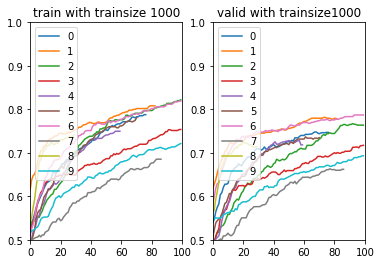

2000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.sgd.SGD'> 0.0001
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131


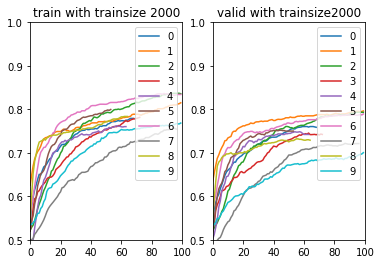

4000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.sgd.SGD'> 0.0001
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131


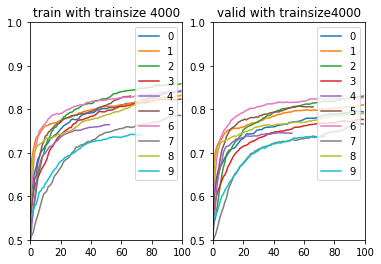

In [28]:
for trsize in [1000, 2000, 4000]:
    train_size = trsize
    print(train_size, test_size, num_layer, train_valid_split, channels, 
          patience,weight_decay, batch_size, optimizer, lr)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for i in range(10):
        all_aucs_train, all_aucs_valid = train(i)
        ax1.plot(all_aucs_train, label=str(i))
        ax2.plot(all_aucs_valid, label=str(i))

    ax1.set_xlim(0, 100)
    ax1.set_ylim(0.5, 1)
    ax2.set_xlim(0, 100)
    ax2.set_ylim(0.5, 1)
    ax1.legend()
    ax2.legend()
    ax1.set_title("train with trainsize " + str(train_size))
    ax2.set_title("valid with trainsize" + str(train_size))
    plt.show()

## Tweaking training set size with Adam

1000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0001
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131


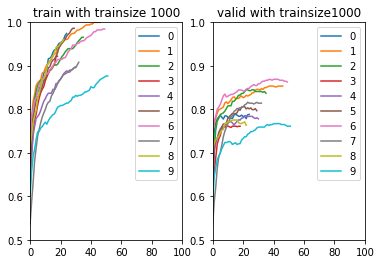

2000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0001
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131


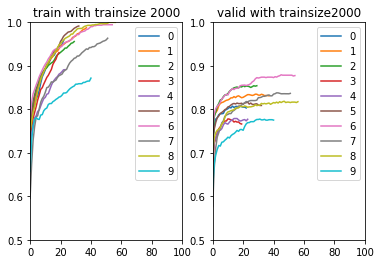

4000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0001
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131


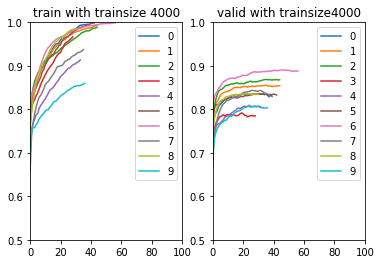

In [30]:
for trsize in [1000, 2000, 4000]:
    train_size = trsize
    print(train_size, test_size, num_layer, train_valid_split, channels, 
          patience,weight_decay, batch_size, optimizer, lr)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for i in range(10):
        all_aucs_train, all_aucs_valid = train(i)
        ax1.plot(all_aucs_train, label=str(i))
        ax2.plot(all_aucs_valid, label=str(i))

    ax1.set_xlim(0, 100)
    ax1.set_ylim(0.5, 1)
    ax2.set_xlim(0, 100)
    ax2.set_ylim(0.5, 1)
    ax1.legend()
    ax2.legend()
    ax1.set_title("train with trainsize " + str(train_size))
    ax2.set_title("valid with trainsize" + str(train_size))
    plt.show()

## Tweaking learning rate

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0001 50
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131


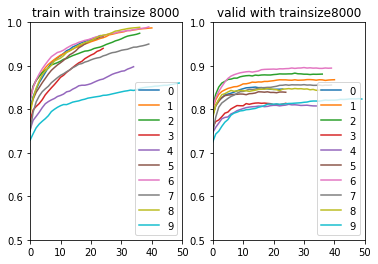

In [43]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0001
verbose = False
num_epochs = 50
plot_training()

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.001 50
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131


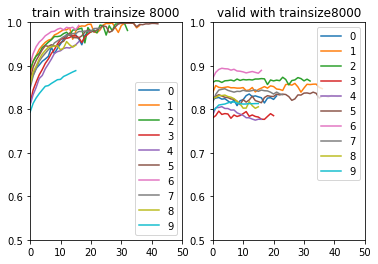

In [44]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.001
verbose = False
num_epochs = 50
plot_training()

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.01 50
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131


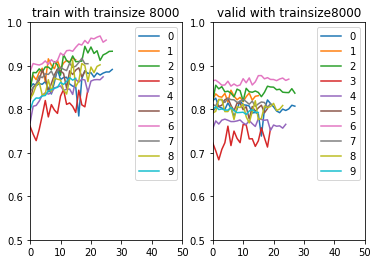

In [45]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.01
verbose = False
num_epochs = 50
plot_training()

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 1e-05 50
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131


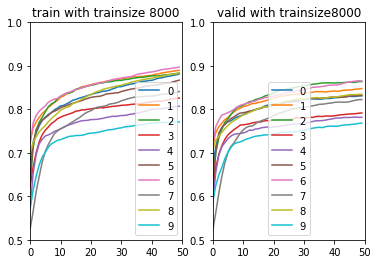

In [46]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.00001
verbose = False
num_epochs = 50
plot_training()

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 1e-06 50
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131


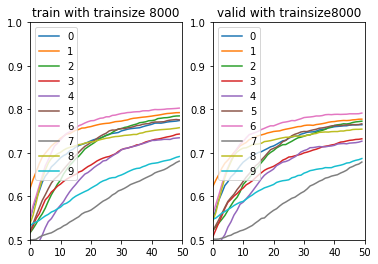

In [47]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.000001
verbose = False
num_epochs = 50
plot_training()

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0005 50
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


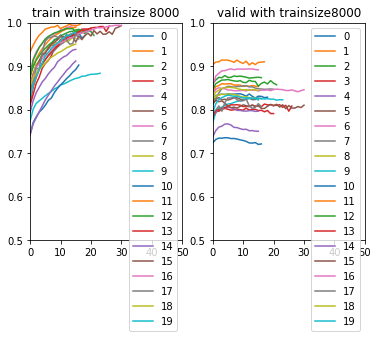

In [52]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0005
verbose = False
num_epochs = 50
n_genes = 20
plot_training()

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0005 5
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


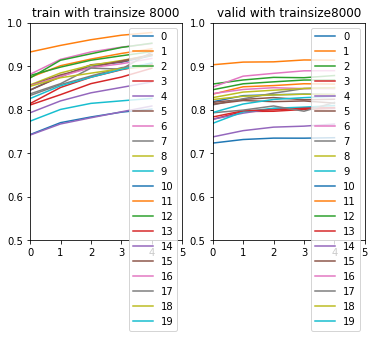

In [53]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0005
verbose = False
num_epochs = 5
n_genes = 20
plot_training()

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0005 2
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


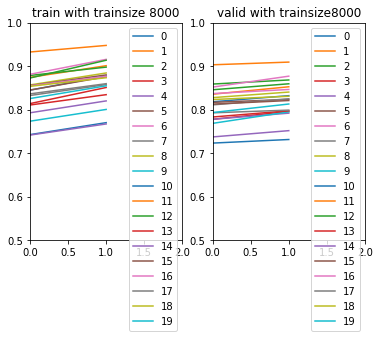

In [54]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0005
verbose = False
num_epochs = 2
n_genes = 20
plot_training()

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0007 2
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


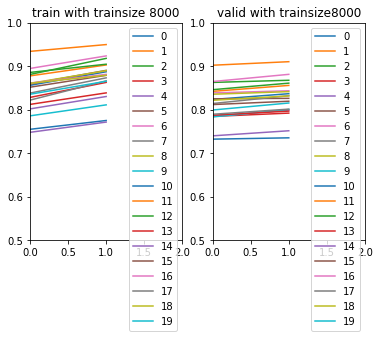

In [55]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 2
n_genes = 20
plot_training()

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0003 2
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


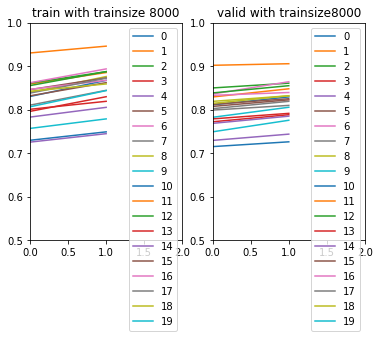

In [56]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0003
verbose = False
num_epochs = 2
n_genes = 20
plot_training()

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0009 2
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


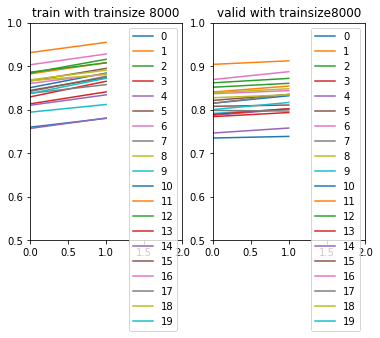

In [57]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0009
verbose = False
num_epochs = 2
n_genes = 20
plot_training()

8000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0011 2
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


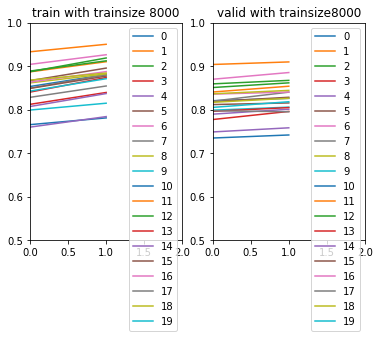

In [58]:
train_size = 8000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0011
verbose = False
num_epochs = 2
n_genes = 20
plot_training()

9000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0007 4
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


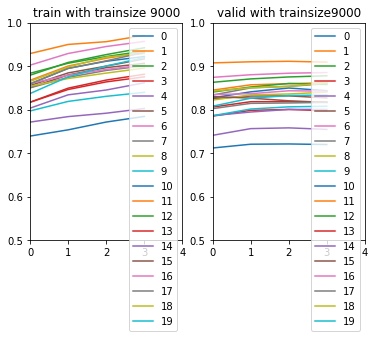

In [60]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 4
n_genes = 20
plot_training()

## Tweaking weight decay

9000 1000 1 0.5 16 10 0.0001 10 <class 'torch.optim.adam.Adam'> 0.0005 4
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


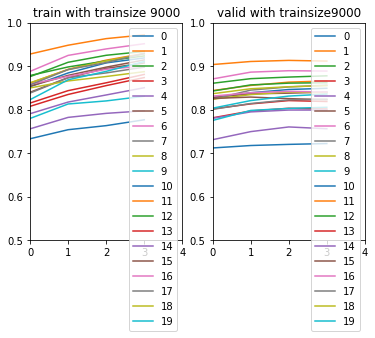

In [61]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.0001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0005
verbose = False
num_epochs = 4
n_genes = 20
plot_training()

9000 1000 1 0.5 16 10 0.001 10 <class 'torch.optim.adam.Adam'> 0.0007 4
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


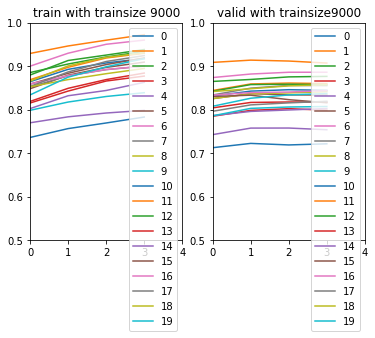

In [62]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 4
n_genes = 20
plot_training()

9000 1000 1 0.5 16 10 1e-05 10 <class 'torch.optim.adam.Adam'> 0.0007 4
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


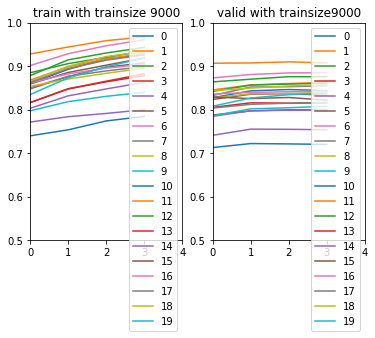

In [63]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.00001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 4
n_genes = 20
plot_training()

9000 1000 1 0.5 16 10 1e-06 10 <class 'torch.optim.adam.Adam'> 0.0007 4
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


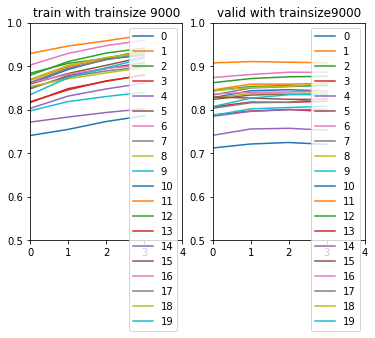

In [64]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 4
n_genes = 20
plot_training()

9000 1000 1 0.5 16 10 0.01 10 <class 'torch.optim.adam.Adam'> 0.0007 4
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


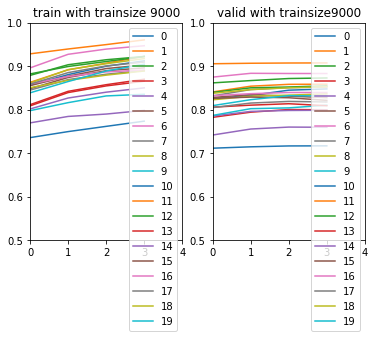

In [65]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.01
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 4
n_genes = 20
plot_training()

9000 1000 1 0.5 16 10 0.1 10 <class 'torch.optim.adam.Adam'> 0.0007 4
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


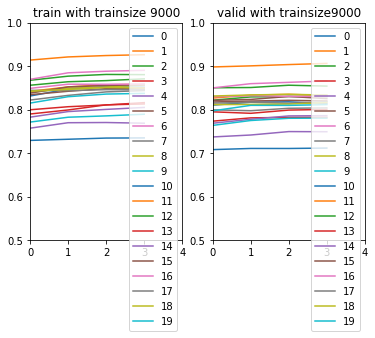

In [66]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.1
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 4
n_genes = 20
plot_training()

9000 1000 1 0.5 16 10 1 10 <class 'torch.optim.adam.Adam'> 0.0007 4
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


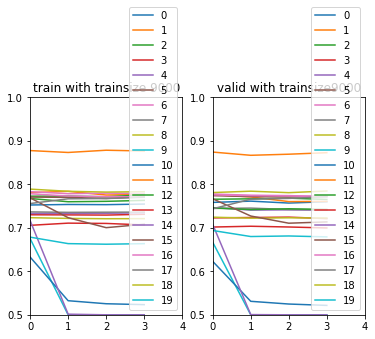

In [67]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=1
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 4
n_genes = 20
plot_training()

9000 1000 1 0.5 16 10 10 10 <class 'torch.optim.adam.Adam'> 0.0007 2
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


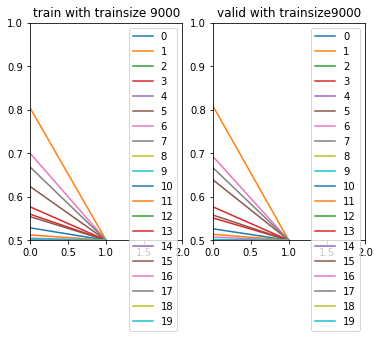

In [68]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=10
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 2
n_genes = 20
plot_training()

## Tweaking number of channels

9000 1000 1 0.5 16 10 1e-08 10 <class 'torch.optim.adam.Adam'> 0.0007 2
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


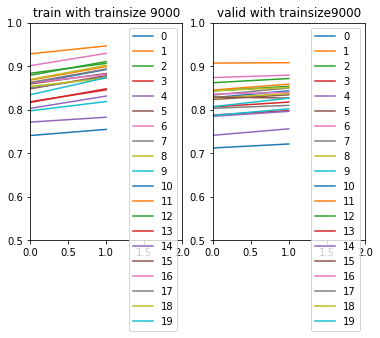

In [69]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=16
patience=10
weight_decay=0.00000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 2
n_genes = 20
plot_training()

9000 1000 1 0.5 32 10 1e-08 10 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


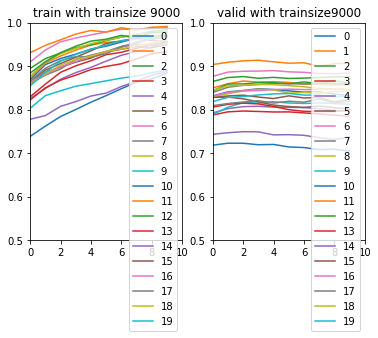

In [73]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=32
patience=10
weight_decay=0.00000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

9000 1000 1 0.5 64 10 1e-08 10 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


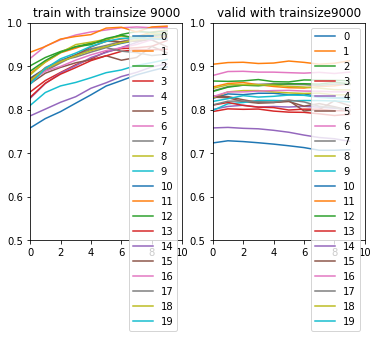

In [74]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=64
patience=10
weight_decay=0.00000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

9000 1000 1 0.5 128 10 1e-08 10 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


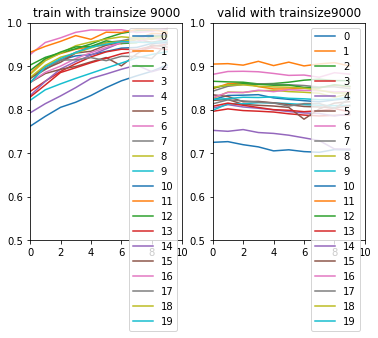

In [75]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=128
patience=10
weight_decay=0.00000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

9000 1000 1 0.5 8 10 1e-08 10 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


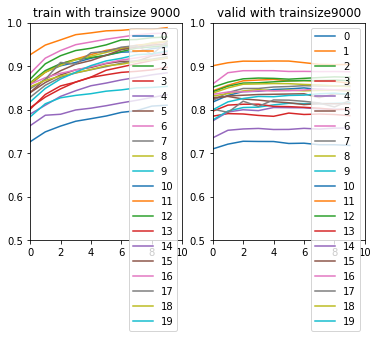

In [76]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=8
patience=10
weight_decay=0.00000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

9000 1000 1 0.5 4 10 1e-08 10 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


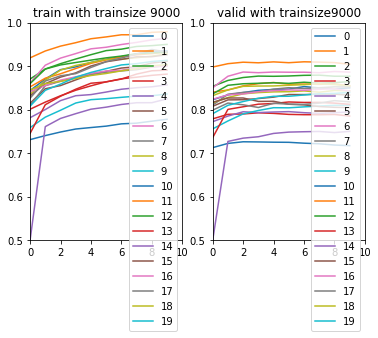

In [77]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=4
patience=10
weight_decay=0.00000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

## Tweaking depth of the network

9000 1000 0 0.5 32 10 1e-08 10 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


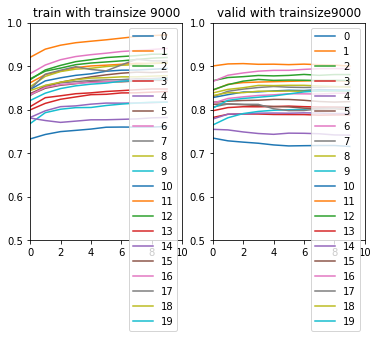

In [78]:
train_size = 9000
test_size = 1000
num_layer=0
dropout=False
train_valid_split=0.5
channels=32
patience=10
weight_decay=0.00000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

9000 1000 2 0.5 32 10 1e-08 10 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


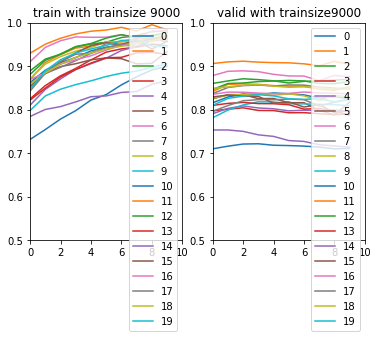

In [79]:
train_size = 9000
test_size = 1000
num_layer=2
dropout=False
train_valid_split=0.5
channels=32
patience=10
weight_decay=0.00000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

9000 1000 3 0.5 32 10 1e-08 10 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


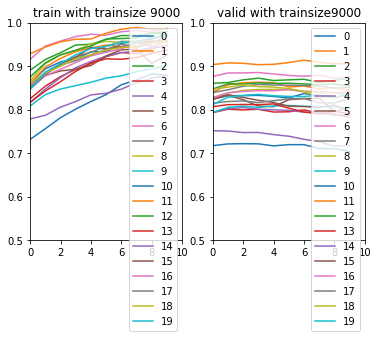

In [80]:
train_size = 9000
test_size = 1000
num_layer=3
dropout=False
train_valid_split=0.5
channels=32
patience=10
weight_decay=0.00000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

9000 1000 4 0.5 32 10 1e-08 10 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


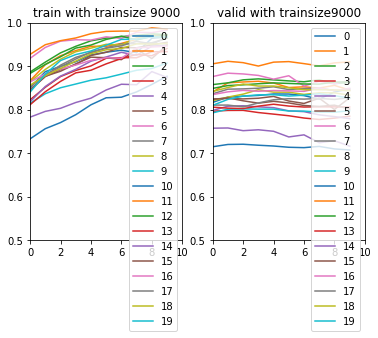

In [81]:
train_size = 9000
test_size = 1000
num_layer=4
dropout=False
train_valid_split=0.5
channels=32
patience=10
weight_decay=0.00000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

9000 1000 1 0.5 32 10 1e-08 10 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


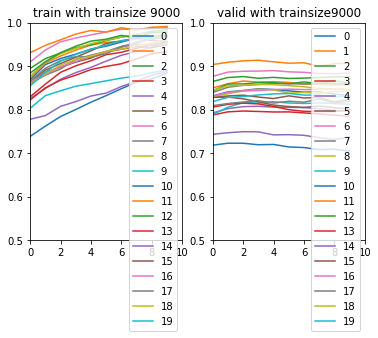

In [82]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=32
patience=10
weight_decay=0.00000001
batch_size=10
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

## Tweaking batch size

9000 1000 1 0.5 32 10 1e-08 1 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


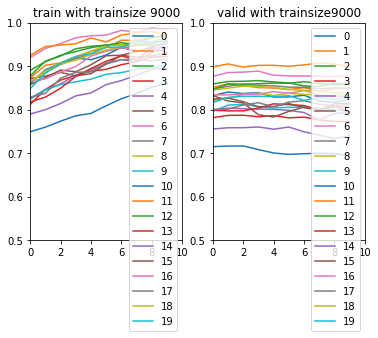

In [83]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=32
patience=10
weight_decay=0.00000001
batch_size=1
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

9000 1000 1 0.5 32 10 1e-08 5 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


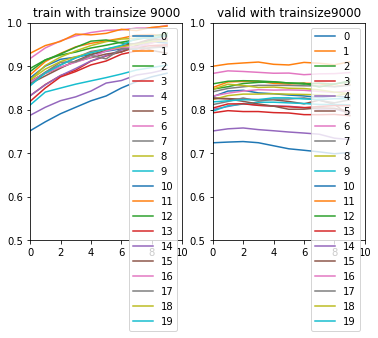

In [84]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=32
patience=10
weight_decay=0.00000001
batch_size=5
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

9000 1000 1 0.5 32 10 1e-08 20 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


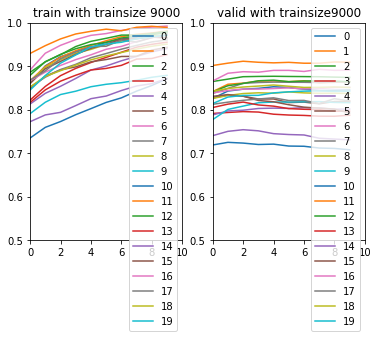

In [85]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=32
patience=10
weight_decay=0.00000001
batch_size=20
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()

9000 1000 1 0.5 32 10 1e-08 50 <class 'torch.optim.adam.Adam'> 0.0007 10
gene DOCK1 neighbors 861
gene FBXO8 neighbors 657
gene ZFC3H1 neighbors 516
gene OXTR neighbors 676
gene ENPP6 neighbors 330
gene EPB41L1 neighbors 697
gene TAF10 neighbors 553
gene MINDY1 neighbors 343
gene SPOP neighbors 931
gene ZNF548 neighbors 131
gene HEMGN neighbors 352
gene MYL9 neighbors 1677
gene ATF6 neighbors 989
gene RGS14 neighbors 545
gene SLC28A2 neighbors 322
gene ELAVL2 neighbors 1266
gene GRHL3 neighbors 400
gene EGF neighbors 4444
gene SCRN2 neighbors 311
gene SOCS6 neighbors 562


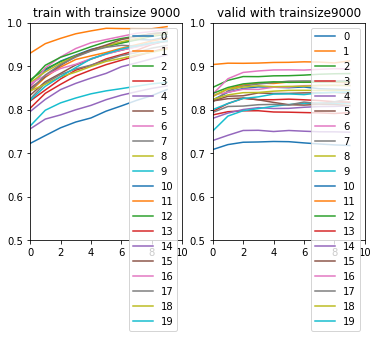

In [86]:
train_size = 9000
test_size = 1000
num_layer=1
dropout=False
train_valid_split=0.5
channels=32
patience=10
weight_decay=0.00000001
batch_size=50
optimizer=torch.optim.Adam
lr=0.0007
verbose = False
num_epochs = 10
n_genes = 20
plot_training()